In [1]:
#get community data for zip code
import matplotlib.pyplot as plt
import zipcodes
import pandas as pd
import json
import http.client


In [2]:
#---------------------------------------------------------------#
#          User inputs 5-digit Zipcode to generate lat / lng
#---------------------------------------------------------------#

target_zip = input("Which zipcode would you like to score? ")
y = True
while y ==True:
    if len(zipcodes.matching(target_zip)) == 0:
        print("That is not a valid zip code")
        target_zip = input("Please try a new zipcode ")
    else:
        y = False

lat = zipcodes.matching(target_zip)[0]["lat"]
lng = zipcodes.matching(target_zip)[0]["long"]

Which zipcode would you like to score? 22314


In [3]:
#---------------------------------------------------------------#
#Query Community API and return the results as JSON object 'resp'

#API URL: https://developer.onboard-apis.com/docs
#---------------------------------------------------------------#


def get_community_data(target_zip):

   #Onboard API Key
    onboard_api_key = "727ca1bf9168cb8329806cb7e0eef3f6"

    conn = http.client.HTTPSConnection("search.onboard-apis.com")
    headers = {
        'accept': "application/json",
        'apikey': "727ca1bf9168cb8329806cb7e0eef3f6",
        } 

    community_url = "/communityapi/v2.0.0/Area/Full/?"
    queries="AreaId=ZI"+target_zip
    query_url = community_url + queries
    conn.request("GET", query_url, headers=headers) 
    res = conn.getresponse()
    resp = json.loads(res.read())
    return resp
    


In [4]:
#---------------------------------------------------------------#
# Extract age demographics from the 'resp' JSON object
# Provides a pie chart
#---------------------------------------------------------------#

def age_demographics_zip(resp, target_zip):
    resp_keys = list(resp['response'].keys())
    if 'result' not in resp_keys: #check if there is data in 'resp' 
        result = 2       
        print('No results to graph. This zip code may not be valid.')

    else: # If there are results in the 'resp' 
        age_columns = ['age00_04','age05_09','age10_14','age15_19','age20_24','age25_29','age30_34','age35_39','age40_44',
                    'age45_49','age50_54','age55_59','age60_64','age65_69','age70_74','age75_79','age80_84','agegt85']
        labels = []
        age_groups = []
        age_group_values = []
        county_name = resp['response']['result']['package']['item'][0]['countyname']
        for x in age_columns:
            group_name = x
            age_groups.append(x)
            route = resp['response']['result']['package']['item'][0][x]
            age_group_values.append(int(route))
            label = x.replace('age','').replace('_','-').replace('gt85',' >=85') #format labels
            labels.append(label)

        # Create DF with summarized age groups
        age_by_zip = {"Groups": age_groups, "Count": age_group_values}
        age_by_zip_df = pd.DataFrame(age_by_zip)
        _0_09 = age_by_zip_df[0:2]['Count'].sum()
        _10_19 = age_by_zip_df[2:4]['Count'].sum()
        _20_29 = age_by_zip_df[4:6]['Count'].sum()
        _30_39 = age_by_zip_df[6:8]['Count'].sum()
        _40_49 = age_by_zip_df[8:10]['Count'].sum()
        _50_59 = age_by_zip_df[10:12]['Count'].sum()
        _60_69 = age_by_zip_df[12:14]['Count'].sum()
        _70_plus = age_by_zip_df[14:18]['Count'].sum()
        grp_sum_lables = ['1-9','10-19','20-29','30-39','40-49','50-59','60-69','>= 70']
        grp_sums = [_0_09,_10_19,_20_29,_30_39,_40_49,_50_59,_60_69,_70_plus]
        grp_dict = {'Groups':grp_sum_lables,'Count':grp_sums}
        grouped_age_df = pd.DataFrame(grp_dict)
        # Determine max value amongst age groups and set this to explode in pie chart
        max_age = grouped_age_df['Count'].idxmax(axis=0, skipna=True)
        explode_params = [0,0,0,0,0,0,0,0,]
        explode_params[max_age] = 0.2
        # Plot pie chart 
        fig = plt.figure(figsize = [10,10])
        plt.pie(grouped_age_df['Count'], shadow=True, startangle=140,explode = explode_params,labels = grouped_age_df['Groups'],autopct="%1.1f%%", pctdistance = .65)
        plt.title("Age Groups for zip code %s\nin %s" %(target_zip,county_name))
    #     plt.savefig("Age_Demographics_PieChar.png")
        return plt.show()
    

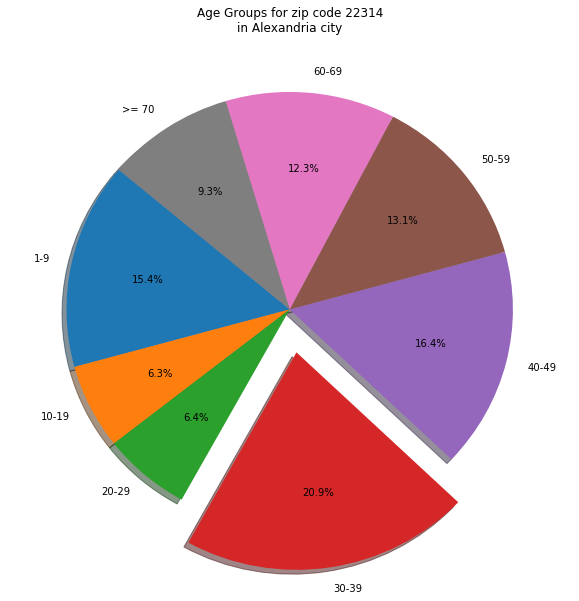

In [7]:
resp = get_community_data(target_zip)
age_demographics_zip(resp,target_zip)